In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 13.8 MB/s eta 0:00:0000:0100:01


In [22]:
import os
DATASET_PATH = "/kaggle/input/m2cai-tool/m2cai16-tool-locations"

if(1):
  ANNOTATIONS_DIR = "/kaggle/input/m2cai-tool/m2cai16-tool-locations/Annotations"
  IMAGES_DIR = "/kaggle/input/m2cai-tool/m2cai16-tool-locations/JPEGImages"
  YOLO_DIR = "/kaggle/working/m2cai-yolo"
  CLASS_LIST_FILE = "/kaggle/input/class-list-1/class_list.txt"

# Create folders
os.makedirs(f"{YOLO_DIR}/images/train", exist_ok=True)
os.makedirs(f"{YOLO_DIR}/images/val", exist_ok=True)
os.makedirs(f"{YOLO_DIR}/images/test", exist_ok=True)
os.makedirs(f"{YOLO_DIR}/labels/train", exist_ok=True)
os.makedirs(f"{YOLO_DIR}/labels/val", exist_ok=True)
os.makedirs(f"{YOLO_DIR}/labels/test", exist_ok=True)

In [23]:
print("✅ Example check:", os.path.exists("/kaggle/input/m2cai-tool/m2cai16-tool-locations/JPEGImages/v03_114050.jpg"))

✅ Example check: True


In [24]:
import os
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import shutil

# === Load class list ===
with open(CLASS_LIST_FILE, "r") as f:
    class_names = [line.strip() for line in f.readlines()]
class_to_id = {name: idx for idx, name in enumerate(class_names)}
print("✅ Loaded classes:", class_to_id)

# === Setup output folders ===
for split in ["train", "val", "test"]:
    os.makedirs(f"{YOLO_DIR}/images/{split}", exist_ok=True)
    os.makedirs(f"{YOLO_DIR}/labels/{split}", exist_ok=True)

# === Load all XML files ===
xml_files = [f for f in os.listdir(ANNOTATIONS_DIR) if f.endswith(".xml")]
print(f"📁 Found {len(xml_files)} annotation files.")

# === Split the dataset ===
train_files, temp_files = train_test_split(xml_files, test_size=0.30, random_state=42)
val_files, test_files = train_test_split(temp_files, test_size=0.5, random_state=42)

# === VOC to YOLO Converter ===
def convert_annotation(xml_path, output_path, img_filename):
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()
        img_w = int(root.find("size/width").text)
        img_h = int(root.find("size/height").text)

        label_lines = []
        for obj in root.findall("object"):
            cls = obj.find("name").text.strip().lower()
            if cls not in class_to_id:
                print(f"⚠️ Unknown class '{cls}' in {img_filename}, skipping.")
                continue

            cls_id = class_to_id[cls]

            bbox = obj.find("bndbox")
            xmin = float(bbox.find("xmin").text)
            ymin = float(bbox.find("ymin").text)
            xmax = float(bbox.find("xmax").text)
            ymax = float(bbox.find("ymax").text)

            # YOLO format
            x_center = ((xmin + xmax) / 2) / img_w
            y_center = ((ymin + ymax) / 2) / img_h
            width = (xmax - xmin) / img_w
            height = (ymax - ymin) / img_h

            label_lines.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

        if label_lines:
            with open(output_path, "w") as f:
                f.write("\n".join(label_lines))
        else:
            print(f"⚠️ No objects found in {img_filename}. Skipping label file.")
    except Exception as e:
        print(f"❌ Error in {img_filename}: {e}")

# === Copy and Convert ===
def process_set(file_list, set_type):
    print(f"🔄 Processing {set_type} set with {len(file_list)} samples...")
    for xml_file in file_list:
        #file_id = xml_file.replace(".xml", "")
        file_id = os.path.splitext(os.path.basename(xml_file))[0]
        img_file = f"{file_id}.jpg"
        src_img = os.path.join(IMAGES_DIR, img_file)
        #print(f"🧪 DEBUG img_file = {img_file}")
        dst_img = os.path.join(YOLO_DIR, f"images/{set_type}", img_file)
        label_path = os.path.join(YOLO_DIR, f"labels/{set_type}", f"{file_id}.txt")

        if not os.path.exists(src_img):
            print(f"⚠️ Missing image: {src_img}")
            continue

        shutil.copy2(src_img, dst_img)
        convert_annotation(os.path.join(ANNOTATIONS_DIR, xml_file), label_path, file_id)

# === Run ===
process_set(train_files, "train")
process_set(val_files, "val")
process_set(test_files, "test")

print("✅ Conversion complete!")


✅ Loaded classes: {'grasper': 0, 'bipolar': 1, 'hook': 2, 'scissors': 3, 'clipper': 4, 'irrigator': 5, 'specimenbag': 6}
📁 Found 2811 annotation files.
🔄 Processing train set with 1967 samples...
🔄 Processing val set with 422 samples...
🔄 Processing test set with 422 samples...
✅ Conversion complete!


In [25]:
import yaml

data_yaml = {
    'train': '/kaggle/working/m2cai-yolo/images/train',
    'val': '/kaggle/working/m2cai-yolo/images/val',
    'test': '/kaggle/working/m2cai-yolo/images/test',
    'nc': 7,
    'names': ['Grasper', 'Bipolar', 'Hook', 'Scissors', 'Clipper', 'Irrigator', 'SpecimenBag']
}

with open('/kaggle/working/m2cai-yolo/data.yaml', 'w') as f:
    yaml.dump(data_yaml, f)

print("✅ data.yaml file created in /kaggle/working/m2cai-yolo/")


✅ data.yaml file created in /kaggle/working/m2cai-yolo/


In [26]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # Or yolov8s.pt, yolov8m.pt, etc.
model.train(data="/kaggle/working/m2cai-yolo/data.yaml", epochs=50, imgsz=640, batch=16, name="m2cai_yolo")


Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/m2cai-yolo/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=m2cai_yolo, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=

100%|██████████| 755k/755k [00:00<00:00, 18.1MB/s]


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 74.9MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/m2cai-yolo/labels/train... 1967 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1967/1967 [00:01<00:00, 1010.63it/s]

train: New cache created: /kaggle/working/m2cai-yolo/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /kaggle/working/m2cai-yolo/labels/val... 422 images, 0 backgrounds, 0 corrupt: 100%|██████████| 422/422 [00:00<00:00, 973.86it/s]

val: New cache created: /kaggle/working/m2cai-yolo/labels/val.cache


Plotting labels to runs/detect/m2cai_yolo/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/m2cai_yolo
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.05G      1.847      3.564      1.822         41        640: 100%|██████████| 123/123 [00:23<00:00,  5.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:03<00:00,  3.62it/s]


                   all        422        581       0.47      0.415      0.378      0.186

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.15G      1.679      2.489      1.626         48        640: 100%|██████████| 123/123 [00:20<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.55it/s]

                   all        422        581      0.571       0.52       0.55      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.15G      1.658       2.17      1.639         48        640: 100%|██████████| 123/123 [00:20<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.33it/s]

                   all        422        581      0.584      0.542      0.622      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.15G      1.665      1.943      1.618         44        640: 100%|██████████| 123/123 [00:20<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.39it/s]

                   all        422        581      0.484      0.628      0.618      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.15G      1.629      1.715      1.584         37        640: 100%|██████████| 123/123 [00:21<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.53it/s]

                   all        422        581      0.679      0.712      0.748      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.15G       1.57      1.577      1.547         45        640: 100%|██████████| 123/123 [00:20<00:00,  6.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.42it/s]

                   all        422        581      0.775      0.702      0.794       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.15G      1.545      1.476      1.529         45        640: 100%|██████████| 123/123 [00:22<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.57it/s]

                   all        422        581      0.847      0.753      0.862      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.15G      1.529      1.421      1.515         53        640: 100%|██████████| 123/123 [00:21<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.33it/s]


                   all        422        581      0.824      0.812      0.887      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.15G      1.501      1.322      1.494         47        640: 100%|██████████| 123/123 [00:20<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.53it/s]

                   all        422        581      0.826      0.808      0.879      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.15G      1.492      1.281      1.483         33        640: 100%|██████████| 123/123 [00:20<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.33it/s]

                   all        422        581      0.791       0.79      0.865      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.15G      1.475      1.221      1.466         43        640: 100%|██████████| 123/123 [00:20<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.25it/s]

                   all        422        581      0.868      0.866      0.915       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.15G      1.453      1.169      1.449         40        640: 100%|██████████| 123/123 [00:21<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.57it/s]

                   all        422        581      0.862      0.838      0.905      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.15G      1.435      1.156      1.439         45        640: 100%|██████████| 123/123 [00:20<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.93it/s]

                   all        422        581      0.857      0.875      0.916      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.15G      1.429      1.103      1.432         40        640: 100%|██████████| 123/123 [00:20<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.63it/s]

                   all        422        581      0.889      0.841      0.917      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.15G      1.409      1.039      1.397         33        640: 100%|██████████| 123/123 [00:20<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.68it/s]

                   all        422        581      0.907      0.851      0.923      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.15G      1.387      1.043      1.407         51        640: 100%|██████████| 123/123 [00:20<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.92it/s]


                   all        422        581      0.855      0.893      0.921      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.15G      1.377     0.9935      1.387         40        640: 100%|██████████| 123/123 [00:19<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.74it/s]

                   all        422        581      0.896      0.886      0.935      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.15G      1.368     0.9746      1.381         36        640: 100%|██████████| 123/123 [00:20<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.72it/s]

                   all        422        581      0.917      0.912      0.946      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.15G      1.281     0.8524      1.315         44        640: 100%|██████████| 123/123 [00:19<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.28it/s]

                   all        422        581      0.917      0.912      0.954      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.15G      1.247     0.8209      1.293         46        640: 100%|██████████| 123/123 [00:19<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.72it/s]

                   all        422        581      0.941      0.898      0.956      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.15G       1.24     0.8342      1.304         35        640: 100%|██████████| 123/123 [00:19<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.37it/s]

                   all        422        581      0.946      0.915      0.959      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.15G      1.237     0.8126      1.288         33        640: 100%|██████████| 123/123 [00:19<00:00,  6.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.90it/s]

                   all        422        581      0.905      0.927      0.955       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.15G      1.207     0.7876      1.274         38        640: 100%|██████████| 123/123 [00:19<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.51it/s]

                   all        422        581      0.935       0.93      0.964      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.15G      1.212     0.7921      1.275         33        640: 100%|██████████| 123/123 [00:19<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.15it/s]

                   all        422        581       0.94      0.908      0.956      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.15G      1.208     0.7885      1.282         35        640: 100%|██████████| 123/123 [00:19<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.18it/s]

                   all        422        581      0.914      0.923      0.958      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.15G       1.17     0.7534      1.262         41        640: 100%|██████████| 123/123 [00:19<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.62it/s]


                   all        422        581      0.948      0.911       0.96      0.606

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.15G      1.169     0.7534       1.25         46        640: 100%|██████████| 123/123 [00:19<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.95it/s]

                   all        422        581      0.949      0.916      0.962      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.15G      1.151     0.7281      1.243         43        640: 100%|██████████| 123/123 [00:19<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.94it/s]

                   all        422        581      0.953       0.93      0.965      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.15G      1.138     0.7176      1.236         44        640: 100%|██████████| 123/123 [00:19<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.93it/s]

                   all        422        581      0.938      0.914      0.952      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.15G      1.137     0.7112      1.225         52        640: 100%|██████████| 123/123 [00:19<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.35it/s]

                   all        422        581      0.936      0.931      0.965      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.15G      1.107     0.6926      1.209         47        640: 100%|██████████| 123/123 [00:19<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.10it/s]


                   all        422        581      0.966      0.938      0.965      0.608

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.15G      1.114     0.6846      1.213         45        640: 100%|██████████| 123/123 [00:19<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.25it/s]

                   all        422        581      0.945      0.943      0.967      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.15G      1.088     0.6667      1.206         50        640: 100%|██████████| 123/123 [00:19<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.15it/s]


                   all        422        581       0.95      0.927      0.962       0.61

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.15G      1.097      0.679       1.21         41        640: 100%|██████████| 123/123 [00:19<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.12it/s]

                   all        422        581      0.948      0.939      0.965      0.618


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.15G      1.013     0.5273      1.188         21        640: 100%|██████████| 123/123 [00:19<00:00,  6.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.40it/s]


                   all        422        581      0.937      0.939      0.964      0.614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.15G     0.9772     0.4907      1.151         21        640: 100%|██████████| 123/123 [00:19<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.03it/s]

                   all        422        581      0.955      0.921      0.967      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.15G     0.9666     0.4793      1.147         21        640: 100%|██████████| 123/123 [00:19<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.82it/s]

                   all        422        581      0.942      0.929      0.958      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.15G     0.9455     0.4784      1.141         19        640: 100%|██████████| 123/123 [00:19<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.97it/s]

                   all        422        581      0.945      0.937      0.962      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.15G     0.9345     0.4627      1.126         23        640: 100%|██████████| 123/123 [00:19<00:00,  6.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.12it/s]

                   all        422        581      0.959      0.937      0.965      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.15G     0.9124     0.4526      1.115         20        640: 100%|██████████| 123/123 [00:19<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  6.84it/s]

                   all        422        581       0.96      0.923      0.966      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.15G     0.8987     0.4456      1.107         16        640: 100%|██████████| 123/123 [00:19<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:01<00:00,  7.19it/s]

                   all        422        581      0.965      0.931       0.97      0.635



50 epochs completed in 0.314 hours.
Optimizer stripped from runs/detect/m2cai_yolo/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/m2cai_yolo/weights/best.pt, 6.2MB

Validating runs/detect/m2cai_yolo/weights/best.pt...
Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 14/14 [00:02<00:00,  5.34it/s]


                   all        422        581      0.965      0.931       0.97      0.635
               Grasper        164        204       0.91      0.846      0.933      0.564
               Bipolar         65         65      0.968      0.931      0.953      0.586
                  Hook         44         44          1          1      0.995      0.793
              Scissors         60         60      0.981          1      0.995      0.638
               Clipper         66         66       0.98      0.924      0.979      0.667
             Irrigator         64         64       0.94      0.891      0.971      0.504
           SpecimenBag         78         78      0.972      0.923      0.961       0.69


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 1.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/m2cai_yolo


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dcccd9a3280>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

In [38]:
metrics = model.val(split='test')  # Use test split
print(metrics)

Ultralytics 8.3.103 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /kaggle/working/m2cai-yolo/labels/test.cache... 422 images, 0 backgrounds, 0 corrupt: 100%|██████████| 422/422 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:03<00:00,  8.37it/s]


                   all        422        613      0.953      0.941      0.968       0.63
               Grasper        197        240      0.897      0.875      0.918      0.565
               Bipolar         71         71      0.968      0.944      0.977      0.627
                  Hook         51         51          1      0.959      0.993      0.725
              Scissors         52         52      0.926      0.958       0.98       0.61
               Clipper         57         57      0.978      0.965      0.982      0.675
             Irrigator         68         68      0.985      0.956      0.979      0.581
           SpecimenBag         74         74      0.918      0.932      0.949      0.624


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.5ms preprocess, 2.4ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/m2cai_yolo13
ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7dccd1e93f70>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038

In [39]:
results = model.predict(source="/kaggle/working/m2cai-yolo/images/test", save=True, conf=0.25)


image 1/422 /kaggle/working/m2cai-yolo/images/test/v01_004225.jpg: 384x640 1 Grasper, 16.6ms
image 2/422 /kaggle/working/m2cai-yolo/images/test/v01_007125.jpg: 384x640 2 Graspers, 6.0ms
image 3/422 /kaggle/working/m2cai-yolo/images/test/v01_020150.jpg: 384x640 2 Graspers, 6.2ms
image 4/422 /kaggle/working/m2cai-yolo/images/test/v01_027600.jpg: 384x640 2 Graspers, 1 Scissors, 6.0ms
image 5/422 /kaggle/working/m2cai-yolo/images/test/v01_027625.jpg: 384x640 2 Graspers, 1 Scissors, 5.9ms
image 6/422 /kaggle/working/m2cai-yolo/images/test/v01_027875.jpg: 384x640 2 Graspers, 1 Scissors, 6.1ms
image 7/422 /kaggle/working/m2cai-yolo/images/test/v01_028050.jpg: 384x640 2 Graspers, 1 Scissors, 6.1ms
image 8/422 /kaggle/working/m2cai-yolo/images/test/v01_028150.jpg: 384x640 2 Graspers, 1 Scissors, 6.1ms
image 9/422 /kaggle/working/m2cai-yolo/images/test/v01_028175.jpg: 384x640 2 Graspers, 1 Scissors, 6.1ms
image 10/422 /kaggle/working/m2cai-yolo/images/test/v01_028250.jpg: 384x640 2 Graspers, 1 

In [40]:
print(results[0].save_dir)


runs/detect/m2cai_yolo14


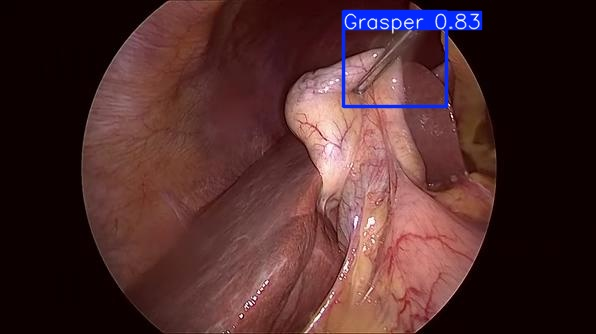

NameError: name 'dis' is not defined

In [42]:
import os
from IPython.display import Image, display

pred_dir = "/kaggle/working/runs/detect/predict/m2cai_yolo14"
display(Image(filename="/kaggle/working/runs/detect/m2cai_yolo14/v01_004225.jpg"))

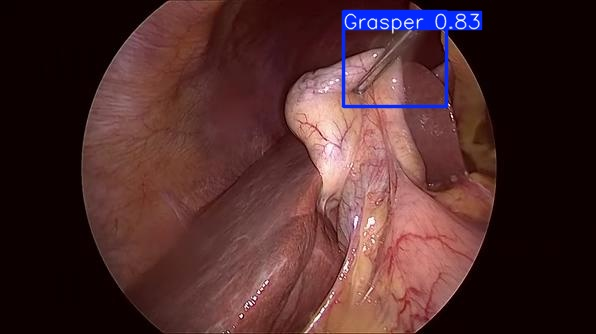

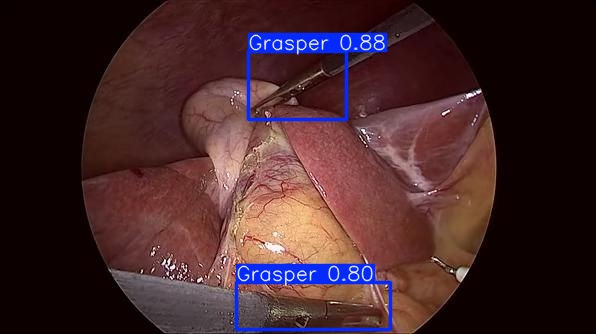

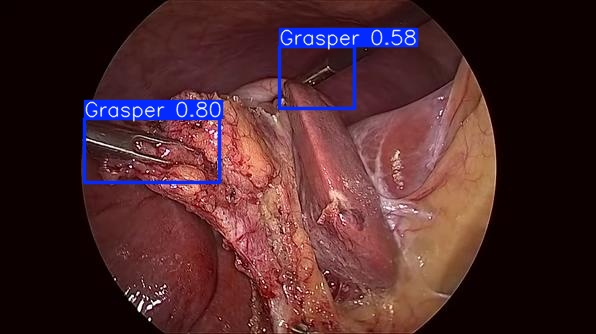

In [ ]:
import os
from IPython.display import Image, display

pred_dir = "/kaggle/working/runs/detect/m2cai_yolo14"

# Loop through and display all images in the predictions folder
for img_file in sorted(os.listdir(pred_dir)):
    if img_file.lower().endswith((".jpg", ".png", ".jpeg")):
        img_path = os.path.join(pred_dir, img_file)
        display(Image(filename=img_path))


In [6]:
from ultralytics import YOLO

# Load your trained model - saved after previous step to prevent any loss of model (or redo the entire process, with this cell too)
model = YOLO("/kaggle/input/trained-yolov8/best.pt")  # Update if path is different

# Run inference on your test video
results = model.predict(source="/kaggle/input/test-vid/shortened3min_vid.mp4", save=True, conf=0.25)

print("✅ Inference done! Output saved in:", results[0].save_dir)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/5412) /kaggle/input/test-vid/shortened3min_vid.mp4: 384x640 1 Grasper, 1 Hook, 90.4ms
video 1/1 (frame 2/5412) /kaggle/input/test-vid/shortened3min_vid.mp4: 384x640 1 Grasper, 1 Hook, 6.7ms
video 1/1 (frame 3/5412) /kaggle/input/test-vid/shortened3min_vid.mp4: 384x640 1 Grasper, 1 Hook, 6.8ms
video 1/1 (frame 4/5412) /kaggle/input/test-vid/shortened3min_vid.mp4: 384x640 1 Grasper, 1 Hook, 7.6ms
video 1/1 (frame 5/5412) /kaggle/input/

In [7]:
from moviepy.editor import VideoFileClip

# Load .avi and convert to .mp4
input_path = "/kaggle/working/runs/detect/predict/shortened3min_vid.avi"
output_path = "/kaggle/working/predicted_output.mp4"

clip = VideoFileClip(input_path)
clip.write_videofile(output_path, codec='libx264')

print("✅ Video converted to MP4:", output_path)


Moviepy - Building video /kaggle/working/predicted_output.mp4.
Moviepy - Writing video /kaggle/working/predicted_output.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/predicted_output.mp4
✅ Video converted to MP4: /kaggle/working/predicted_output.mp4
